## pitchfork_review_anlaysis
**Program:** 01_pitchfork_review_analysis.ipynb <br>
**Created by:** Chris Chan<br>
**Date:** Mar 16, 2021<br>
**Purpose:** <br>
. The purpose of the project is to develop a modern jazz artist recommender/discovery based on sub-genres or non-jazz artists somehow linked to the jazz album via pitchfork review text. Upon inspection of reviews (namely jazz reviews) there is high chance of other non-jazz artist referenced to shed light on some similarity. The idea is to take these links as features or search terms in a rec system that would link to the jazz artist. The jazz artists would be cmpared as well given various topics modeled from all of the reviews.

. 1. bring in data, count vectorize, etc. <br>
. 2. preprocessing - clean, lemmatize <br>
. 3. explore:<br>
    . Basic EDA
    . try topic modeling<br>
    . sentiment analysis<br>
    . combining the two<br>

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import NMF

In [2]:
import glob
import os
from collections import defaultdict
import re
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

In [3]:
import nltk
import os
import spacy
import re
import string
import pickle
from itertools import cycle
import matplotlib.pyplot as plt
from nltk import stem
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
from nltk.tokenize import word_tokenize, sent_tokenize, MWETokenizer
from gensim import corpora, models, similarities, matutils
from sklearn.decomposition import TruncatedSVD, NMF
from corextopic import corextopic, vis_topic
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import plotly.graph_objects as go
import scattertext as st

In [4]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

### Read in data

**We read through all the docments and build a list-of-list of words:**

In [950]:
df = pd.read_csv('/Users/chrischan/Documents/02_Class/Metis/bootcamp/githubrepo/Metis_proj5/data/pitchfork_jazz_clean.csv')

In [951]:
df.head()

,Unnamed: 0,artist,album,score,genre,review,othercat,othercat2,best,date,testing_formula
0,0,Sam Gendel,Fresh Bread,6.5,Jazz,"Fifty-two tracks deep, this archival compendiu...","['Skip to content', 'All Results', 'Home', 'Ne...","Sam Gendel, Jay Balfour, Sam Gendel, cover...",0,March 4 2021,"Skip to content, All Results, Home, News, Revi..."
1,1,Femi Kuti / Made Kuti,Legacy +,7.8,Global,"On the duo’s generation-spanning double album,...","['Skip to content', 'All Results', 'Home', 'Ne...","Femi Kuti, Made Kuti, Joey Akan, Global, F...",0,February 20 2021,"Skip to content, All Results, Home, News, Revi..."
2,2,Archie Shepp / Jason Moran,Let My People Go,7.5,Jazz,These live sets between the saxophonist and pi...,"['Skip to content', 'All Results', 'Home', 'Ne...","Archie Shepp, Jason Moran, Madison Bloom, ...",0,February 15 2021,"Skip to content, All Results, Home, News, Revi..."
3,3,Patricia Brennan,Maquishti,7.4,Experimental,"Challenging but never chaotic, contemplative y...","['Skip to content', 'All Results', 'Home', 'Ne...","Patricia Brennan, Daniel Felsenthal, Experime...",0,January 19 2021,"Skip to content, All Results, Home, News, Revi..."
4,4,Baldi/Gerycz Duo,After Commodore Perry Service Plaza,7.1,Jazz,The second album of improvisational jazz from ...,"['Skip to content', 'All Results', 'Home', 'Ne...","Baldi/Gerycz Duo, Fred Thomas, Experimental,...",0,January 6 2021,"Skip to content, All Results, Home, News, Revi..."


In [1153]:
nonwords=['Skip to content', 'All Results', 'Home', 'News', 'Reviews', 'Albums', 'Tracks', 'Sunday Reviews', '8.0+ Reviews',
          'Best New Music', 'Features', 'Lists & Guides', 'Longform', 'Rising', 'Photo Galleries', 'The Pitch', 'Video',
          'Over/Under', 'Liner Notes', 'Under the Influences', 'On the Records', 'Critical Breakthroughs', 'Podcast', 'GRAMMYS 2021',
          'Newsletter', 'Advertising', 'Masthead', 'Careers', 'Contact', 'Accessibility Help', 'More Pitchfork', 'Pitchfork Music Festival Chicago',
          'Pitchfork Music Festival Paris', 'Pitchfork Music Festival Berlin', 'Pitchfork Radio', 'Home     ','GRAMMYS', 
          'Staff Picks', 'Bandcamp', 'Buy','8.0+ ','8.0+','Back to home', 'Sign','newsletter','here','pitchfork','Pitchfork']


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [953]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624 entries, 0 to 623
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       624 non-null    int64  
 1   artist           624 non-null    object 
 2   album            623 non-null    object 
 3   score            615 non-null    float64
 4   genre            615 non-null    object 
 5   review           624 non-null    object 
 6   othercat         624 non-null    object 
 7   othercat2        615 non-null    object 
 8   best             624 non-null    int64  
 9   date             615 non-null    object 
 10  testing_formula  615 non-null    object 
dtypes: float64(1), int64(2), object(8)
memory usage: 53.8+ KB


In [954]:
df.othercat2.value_counts()

 Miles Davis, Dominique Leone                                                                                                                                                                                                        5
 NOMO, Joe Tangari, Global,  Pop/R&B                                                                                                                                                                                                 4
 Capillary Action, Joe Tangari,  Rock                                                                                                                                                                                                3
 John Zorn, Dominique Leone, Experimental                                                                                                                                                                                            3
 Alog, Mark Richardson, Electronic,  Rock                                   

In [955]:
# pat = r'\b(?:{})\b'.format('|'.join(nonwords))
# print(pat)
# #df['test'] = df['othercat'].replace("'","")
# df['othercat2'] = df['othercat'].str.replace(pat,'')
# df.head()

In [956]:
# import re
# test=[re.sub('[^,a-zA-Z0-9]+', ' ', _) for _ in df['othercat2']]
# test

### Data Cleaning

In [957]:
breaks = lambda x: re.sub("\n", " ", x)
alphanumeric = lambda x: re.sub("\w*\d\w*", "", x)
punc_lower = lambda x: re.sub("[%s]" % re.escape(string.punctuation), "", x.lower())
#punc_lower = lambda x: re.sub("[%s]" % re.escape(string.punctuation), "",x ) # x.lower())

In [958]:
df["review_clean"] = df["review"].map(breaks).map(alphanumeric).map(punc_lower)
df["othercat_clean"] = df["othercat2"].str.lower()
df["artist_clean"] = df["artist"].str.lower()
df["album_clean"] = df["album"].str.lower()

In [959]:
df.head(2)

,Unnamed: 0,artist,album,score,genre,review,othercat,othercat2,best,date,testing_formula,review_clean,othercat_clean,artist_clean,album_clean
0,0,Sam Gendel,Fresh Bread,6.5,Jazz,"Fifty-two tracks deep, this archival compendiu...","['Skip to content', 'All Results', 'Home', 'Ne...","Sam Gendel, Jay Balfour, Sam Gendel, cover...",0,March 4 2021,"Skip to content, All Results, Home, News, Revi...",fiftytwo tracks deep this archival compendium ...,"sam gendel, jay balfour, sam gendel, cover...",sam gendel,fresh bread
1,1,Femi Kuti / Made Kuti,Legacy +,7.8,Global,"On the duo’s generation-spanning double album,...","['Skip to content', 'All Results', 'Home', 'Ne...","Femi Kuti, Made Kuti, Joey Akan, Global, F...",0,February 20 2021,"Skip to content, All Results, Home, News, Revi...",on the duo’s generationspanning double album f...,"femi kuti, made kuti, joey akan, global, f...",femi kuti / made kuti,legacy +


### Some EDA

In [960]:
df.describe()

,Unnamed: 0,score,best
count,624.000000,615.000000,624.000000
mean,311.500000,7.428618,0.070513
std,180.277564,1.157300,0.256215
min,0.000000,1.000000,0.000000
25%,155.750000,7.000000,0.000000
50%,311.500000,7.600000,0.000000
75%,467.250000,8.000000,0.000000
max,623.000000,10.000000,1.000000


In [961]:
df['revdate'] = pd.to_datetime(df['date'])

In [962]:
df=df.drop(['testing_formula','date','othercat'],axis=1)

In [963]:
df.head(2)

,Unnamed: 0,artist,album,score,genre,review,othercat2,best,review_clean,othercat_clean,artist_clean,album_clean,revdate
0,0,Sam Gendel,Fresh Bread,6.5,Jazz,"Fifty-two tracks deep, this archival compendiu...","Sam Gendel, Jay Balfour, Sam Gendel, cover...",0,fiftytwo tracks deep this archival compendium ...,"sam gendel, jay balfour, sam gendel, cover...",sam gendel,fresh bread,2021-03-04
1,1,Femi Kuti / Made Kuti,Legacy +,7.8,Global,"On the duo’s generation-spanning double album,...","Femi Kuti, Made Kuti, Joey Akan, Global, F...",0,on the duo’s generationspanning double album f...,"femi kuti, made kuti, joey akan, global, f...",femi kuti / made kuti,legacy +,2021-02-20


### Scores over time

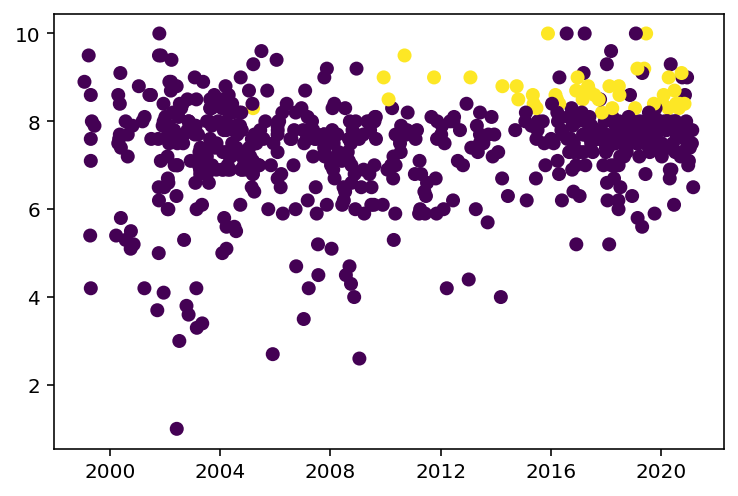

In [964]:
%matplotlib inline
plt.scatter(y='score',x='revdate',data=df,c='best')
plt.show()

### Words per Review

In [996]:
df['totalwords'] = [len(x.split()) for x in df['review_clean'].tolist()]

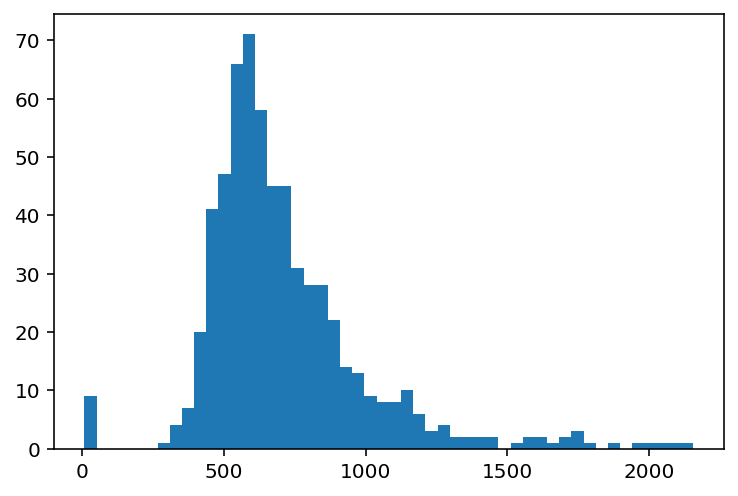

In [1001]:
%matplotlib inline
plt.hist(df['totalwords'],bins=50)
plt.show()

## Pre-processing

### Stop Words

In [1154]:
from sklearn.feature_extraction import text 

my_stop_words = nltk.corpus.stopwords.words('english')
my_stop_words.extend(nonwords)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Lemmatize
**Lemmatizing could be tricky since many common words can be used within artist names (tribe called quest becomes tribe call**

In [966]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
spacy_lemmatize = lambda x: " ".join([token.lemma_ for token in nlp(x)])

In [967]:
df["review_lem"] = df["review_clean"].apply(spacy_lemmatize)
df.head(2)

,Unnamed: 0,artist,album,score,genre,review,othercat2,best,review_clean,othercat_clean,artist_clean,album_clean,revdate,review_lem
0,0,Sam Gendel,Fresh Bread,6.5,Jazz,"Fifty-two tracks deep, this archival compendiu...","Sam Gendel, Jay Balfour, Sam Gendel, cover...",0,fiftytwo tracks deep this archival compendium ...,"sam gendel, jay balfour, sam gendel, cover...",sam gendel,fresh bread,2021-03-04,fiftytwo track deep this archival compendium m...
1,1,Femi Kuti / Made Kuti,Legacy +,7.8,Global,"On the duo’s generation-spanning double album,...","Femi Kuti, Made Kuti, Joey Akan, Global, F...",0,on the duo’s generationspanning double album f...,"femi kuti, made kuti, joey akan, global, f...",femi kuti / made kuti,legacy +,2021-02-20,on the duo ’s generationspanne double album fe...


**for future ref - everything that is capitalized could be a named entity**

In [968]:
df.review_lem[135]

'the minneapolis synthpop band team up with a berlinbased orchestra in an attempt to reckon with the trial of our time you have to admire poliça ’s willingness to break their own mold in   with two album \' worth of hazy breakup song under their belt the minneapolis fivepiece abruptly pivot into political consciousness and trade some of their rock instinct in for a smattering of pop motif the result album united crusher falter at time but it be a goodfaith effort to engage with the national mood poliça read the room and respond accordingly poliça ’s late album be the product of another reinvention in merge with s t a r g a z e the berlinbase orchestral collective lead by conductor andré de ridder they ’ve more than double their lineup with all those extra body in the room the deep dark chasm that fracture their early work separate singer channy leaneagh ’s voice from producer ryan olson ’s rumble synth begin to fill in the result sound feel new to be sure but mostly in the sense that i

In [969]:
#df['review_clean']=df['review_clean'].str.replace('"', '')
df['review_clean2'] = df['review_clean'].map(lambda x: re.sub(r'\W', ' ', x))

In [ ]:
df.review_clean2[135]

### Lets start with a basic approach:
**1. TFIDF**<br>
**2. Cosine Similarity**<br>
**3. Check recommendations**

In [974]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
my_stop_words

**TFIDF**

In [976]:
tfidf = TfidfVectorizer(analyzer='word', stop_words=my_stop_words)

### Apply matrix to REVIEW CLEAN text - this is what's used for COSINE SIM

In [977]:
rev_matrix= tfidf.fit_transform(df['review_clean2'])

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['2021', 'accessibility', 'advertising', 'albums', 'back', 'bandcamp', 'berlin', 'best', 'breakthroughs', 'buy', 'careers', 'chicago', 'contact', 'content', 'critical', 'features', 'festival', 'galleries', 'grammys', 'guides', 'help', 'home', 'influences', 'liner', 'lists', 'longform', 'masthead', 'music', 'new', 'news', 'notes', 'paris', 'photo', 'picks', 'pitch', 'podcast', 'radio', 'records', 'results', 'reviews', 'rising', 'sign', 'skip', 'staff', 'sunday', 'tracks', 'video'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [978]:
rev_matrix.shape

(624, 33467)

In [979]:
rev_matrix

<624x33467 sparse matrix of type '<class 'numpy.float64'>'
	with 203724 stored elements in Compressed Sparse Row format>

In [980]:
# take a peek at the each review and words

print('Sparse Matrix')
# A compressed version; the "sparse" matrix.
print(type(rev_matrix))
#print(rev_matrix)[0][0]

Sparse Matrix
<class 'scipy.sparse.csr.csr_matrix'>


In [981]:
# change to array for dataframe 

print ('Matrix')
rev_matrix_arr = rev_matrix.toarray()
print(type(rev_matrix_arr))
print(rev_matrix_arr)

Matrix
<class 'numpy.ndarray'>
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Doc word dataframe

In [982]:
pd.DataFrame(rev_matrix_arr, columns=tfidf.get_feature_names())

,aa,aaahk,aaahs,aacm,aahs,aaly,aap,aaron,aarp,aarset,...,ólafur,órgãos,öyster,ørnes,øya,übergenre,überhip,überinfluence,風物詩,옛날이야기
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
620,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
622,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Cosine similarity (Based on Clean Review)
. This is what we can regenerate based on input parmeters (I think)

In [983]:
cosine_similarities = cosine_similarity(rev_matrix)

In [984]:
len(cosine_similarities)

624

In [1626]:
np.save('cosine_sim.npy', cosine_similarities)
#cosine_similarities = np.load('cosine_sim.npy')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [985]:
similarities = {}

In [986]:
for i in range(len(cosine_similarities)):
    
    # Sort each element in cosine_similarities and get the indexes of the artists
    similar_indices = cosine_similarities[i].argsort()[:-50:-1] 
    
    # Store in similarities each name of the 10 most similar artists
    # Keep the first one as the main search item - and then the remaining similar artists 
    similarities[df['album'].iloc[i]] = [(cosine_similarities[i][x], df['album'][x], df['artist'][x]) for x in similar_indices][0:]

**Enter an album name to get the similarity scores of teh album**

In [987]:
print(similarities['The Secret of Letting Go'])
#print(similarities.values()[0].keys()[0])

[(0.9999999999999996, 'The Secret of Letting Go', 'Lamb'), (0.06846727156342053, 'Real Enemies', "Darcy James Argue's Secret Society"), (0.06781432016720734, 'Report from Iron Mountain', 'Date Course Pentagon Royal Garden'), (0.06581666187247741, 'Offering: Live at Temple University', 'John Coltrane'), (0.06393073100926769, 'Berlin Serengeti', 'Radio Citizen'), (0.061324277643448555, 'Lady Day: The Master Takes and Singles', 'Billie Holiday'), (0.059920291420570246, 'David Axelrod', 'David Axelrod'), (0.05901962290771342, '12 (+1) Imaginary Views', 'Ellery Eskelin'), (0.058826106747715726, 'Same As It Never Was', 'The Herbaliser'), (0.057904409452372685, 'The Golden Age of Apocalypse', 'Thundercat'), (0.0578411858991793, 'Day Breaks', 'Norah Jones'), (0.05752766695329272, 'Love In a Time of Madness', 'José James'), (0.056934887838134565, 'Madness, Love and Mysticism', 'John Zorn'), (0.055852345830604465, 'Miles at the Fillmore - Miles Davis 1970: The Bootleg Series Vol. 3', 'Miles Davi

In [ ]:
# alternate method of the above
import itertools

# Initialize limit  
N = 1
    
# Using islice() + items()  
# Get first N items in dictionary  
out = dict(itertools.islice(similarities.items(), N))  
        
# printing result   
print("Dictionary limited by K is : " + str(out))

### Content Based Recommendation

In [989]:
class ContentBasedRecommender:
    def __init__(self, matrix):
        self.matrix_similar = matrix

    def _print_message(self, album, recom_album,artist):
        rec_items = len(recom_album)        
        
        #print(f'The {rec_items} recommended albums for {album} are:')
        #print(f"{album} by {artist} ") # with {album[0][0]} similarity score")  # if can add artist sim score        
        #print(f'The {rec_items} recommended albums are:') # if can add artist search title
        
        for i in range(rec_items):
            if i==0:
                #print(f"Matched Album Number {i+1}:")
                print(f"{recom_album[i][1]} by {artist}") # with {round(recom_album[i][0],3)} similarity score")  # if can add artist sim score
                print("--------------------")
            else:    
                print(f"Recommended album based on matched (above) {i}:")            
                print(f"{recom_album[i][1]} by {recom_album[i][2]} with {round(recom_album[i][0], 3)} similarity score") 
                print("--------------------")
        
    def recommend(self, recommendation):
        artist = recommendation['artist']
        # Get album to find recommendations for
        album = recommendation['album']
        # Get number of albums to recommend
        similar_albums = recommendation['similar_albums']
        # Get the number of albums most similars from matrix similarities
        recom_album = self.matrix_similar[album][:similar_albums]
        # print each item
        self._print_message(album=album, recom_album=recom_album,artist=artist)

**instantiate rec function**

In [990]:
recommedations = ContentBasedRecommender(similarities)

### Primary function for album recs based on REVIEW CLEAN (lowercase, remove punc, no lem)

In [991]:
def artsimrec(art,artmatch=1,simalb=0):
    # get list of indeces containing the chosen word that's in the review text
    _a= df.index[df['review_clean2'].str.contains(art,na=False)]
    # get only # of keyword matches requested by user
    a=_a[:artmatch]
    
    if a.empty:
        return 'not found'
    
    # if the keyword shows up in more than one review get requested # of recs for each artist that is mentioned    
    else: # len(a)>1:
        print(f"The number of reviews containing {art} are: {len(_a)}") 
        print(f"User requested {len(a)} Matches")
        print(f"User requested {simalb} Recommended albums per Match")
        print("--------------------")
        
        for k,j in enumerate(a):
            print(f"Matched Album Number {k+1}:")
            recommendation = {
               "artist": df['artist'].iloc[j],
               "album": df['album'].iloc[j],
               "similar_albums": simalb+1 # add +1 to obtain the right number of similar albums
            }
            recommedations.recommend(recommendation)


### RUN RECOMMENDER - based on cosine sim

In [1766]:
# select text input, # of matches based on text, # of recs per match
artsimrec('masayuki',10,3)

The number of reviews containing masayuki are: 2
User requested 2 Matches
User requested 3 Recommended albums per Match
--------------------
Matched Album Number 1:
April is the Cruellest Month by Masayuki Takayanagi New Direction Unit
--------------------
Recommended album based on matched (above) 1:
Tribute to Masayuki Takayanagi by Fred Lonberg-Holm / Jim O’Rourke / Weasel Walter with 0.355 similarity score
--------------------
Recommended album based on matched (above) 2:
Bells/Prophecy by Albert Ayler with 0.112 similarity score
--------------------
Recommended album based on matched (above) 3:
New Grass by Albert Ayler with 0.1 similarity score
--------------------
Matched Album Number 2:
Tribute to Masayuki Takayanagi by Fred Lonberg-Holm / Jim O’Rourke / Weasel Walter
--------------------
Recommended album based on matched (above) 1:
April is the Cruellest Month by Masayuki Takayanagi New Direction Unit with 0.355 similarity score
--------------------
Recommended album based on

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Topic Modeling

### Get DF with Review only

In [1016]:
df_rev = df['review_lem']
df_rev.head(3)

0    fiftytwo track deep this archival compendium m...
1    on the duo ’s generationspanne double album fe...
2    these live set between the saxophonist and pia...
Name: review_lem, dtype: object

In [1017]:
# Import TfidfVectorizer and NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF    

### Start with Genre Topics

In [1155]:
# Makes sense to add words like 'jazz' to stopwords

stopadd = ['band','time','get','take','work','detail','familiar','also','miles','mile','davis','coltrane','song','year','way','instrument','minute']
my_stop_words.extend(stopadd)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### NMF Model

In [1156]:
# Create a function to model topics using NMF
def nmf_it(data, mindf, maxdf, n_components, n_top_words, stop_list):
    '''Fits an NMF model and prints top words for each topic.
    
    Parameters:
        data: DataFrame/Series containing only raw texts
        n_samples: number of texts to sample from data
        n_features: length of TF-IDF vectors to calculate
        n_components: number of topics to model
        n_top_words: number of words to print for each topic, ranked by
            frequency
        stop_list: your list of stopwords to remove
    '''
    
    # Get sample of data
    #data_samples = data.sample(n_samples, random_state=1)
    
    # Instantiate and fit TfidfVectorizer
    tfidf_vectorizer = TfidfVectorizer(max_df=maxdf, min_df=mindf,
                                       # max_features=n_features,
                                       stop_words=my_stop_words)

    tfidf = tfidf_vectorizer.fit_transform(data) #(data_samples)
    
    # Fit the NMF model
    nmf = NMF(n_components=n_components, random_state=1, alpha=.1, 
              l1_ratio=.5).fit(tfidf)

    # View top words for each topic
    print("\nTopics in NMF model (Frobenius norm):")
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    
    for topic_idx, topic in enumerate(nmf.components_):
        message = "Topic #{}: ".format(topic_idx+1)
        message += " ".join([tfidf_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    
    return tfidf, nmf

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1157]:
# View top 10 words for 20 topics
tfidf, nmf = nmf_it(df_rev,0.08,0.80,20,10,my_stop_words)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['2021', 'accessibility', 'advertising', 'albums', 'back', 'bandcamp', 'berlin', 'best', 'breakthroughs', 'buy', 'careers', 'chicago', 'contact', 'content', 'critical', 'features', 'festival', 'galleries', 'grammys', 'guides', 'help', 'home', 'influences', 'liner', 'lists', 'longform', 'masthead', 'music', 'new', 'news', 'notes', 'paris', 'photo', 'picks', 'pitch', 'podcast', 'radio', 'records', 'results', 'reviews', 'rising', 'sign', 'sk


Topics in NMF model (Frobenius norm):
Topic #1: record track make new much come seem even feel play
Topic #2: nt really bad disc ca even anyone probably know think
Topic #3: jame singer love contemporary end last pop tribute true stay
Topic #4: rap hiphop beat root flow production producer good underground say
Topic #5: dj mix beat hiphop series cut break disc collaboration track
Topic #6: jazz free modern player scene william tradition structure chord trumpet
Topic #7: parker william brown quartet musician jazz freedom improvisation suite new
Topic #8: group pianist ensemble composition saxophonist player composer performance jazz trumpeter
Topic #9: vocal drum shine synth machine almost harmony experimental go pop
Topic #10: black african people life child power south american experience man
Topic #11: sun city space strange earth noise jazz world reissue vision
Topic #12: blue kind singer world new love state john whose jazz
Topic #13: duo session improvise pair collaboration retur

### Some ideas:
- part of speech (POS) tagging: remove Named Entities to focus on genre
- add specific terms to stoplist

### POS tagging

In [1117]:
# Let's create a function to pull out nouns from a string of text
from nltk import word_tokenize, pos_tag

def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] in ('NN','NNS','NNP','NNPS') # == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return ' '.join(all_nouns)

In [1066]:
df_genre_nouns = pd.DataFrame(df['review_lem'].apply(nouns))
df_genre_nouns.head(2)

,review_lem
0,track deep compendium catchall fact chance hoo...
1,duo ’ s generationspanne album fela lead spiri...


In [1158]:
# View top 10 words for 20 topics
tfidf, nmf = nmf_it(df['review_lem'],0.08,0.80,20,10,my_stop_words)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['2021', 'accessibility', 'advertising', 'albums', 'back', 'bandcamp', 'berlin', 'best', 'breakthroughs', 'buy', 'careers', 'chicago', 'contact', 'content', 'critical', 'features', 'festival', 'galleries', 'grammys', 'guides', 'help', 'home', 'influences', 'liner', 'lists', 'longform', 'masthead', 'music', 'new', 'news', 'notes', 'paris', 'photo', 'picks', 'pitch', 'podcast', 'radio', 'records', 'results', 'reviews', 'rising', 'sign', 'sk


Topics in NMF model (Frobenius norm):
Topic #1: record track make new much come seem even feel play
Topic #2: nt really bad disc ca even anyone probably know think
Topic #3: jame singer love contemporary end last pop tribute true stay
Topic #4: rap hiphop beat root flow production producer good underground say
Topic #5: dj mix beat hiphop series cut break disc collaboration track
Topic #6: jazz free modern player scene william tradition structure chord trumpet
Topic #7: parker william brown quartet musician jazz freedom improvisation suite new
Topic #8: group pianist ensemble composition saxophonist player composer performance jazz trumpeter
Topic #9: vocal drum shine synth machine almost harmony experimental go pop
Topic #10: black african people life child power south american experience man
Topic #11: sun city space strange earth noise jazz world reissue vision
Topic #12: blue kind singer world new love state john whose jazz
Topic #13: duo session improvise pair collaboration retur

In [1070]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

In [1159]:
# CHANGE PARAMS if you need to
# Vectorize the text sample
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=0.08,
                                   stop_words=my_stop_words)

tfidf = tfidf_vectorizer.fit_transform(df['review_lem'])

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['2021', 'accessibility', 'advertising', 'albums', 'back', 'bandcamp', 'berlin', 'best', 'breakthroughs', 'buy', 'careers', 'chicago', 'contact', 'content', 'critical', 'features', 'festival', 'galleries', 'grammys', 'guides', 'help', 'home', 'influences', 'liner', 'lists', 'longform', 'masthead', 'music', 'new', 'news', 'notes', 'paris', 'photo', 'picks', 'pitch', 'podcast', 'radio', 'records', 'results', 'reviews', 'rising', 'sign', 'sk

In [1160]:
# Instantiate the KMeans model and visualizer
kmeans = KMeans(random_state=1)
visualizer = KElbowVisualizer(kmeans, k=(5, 20), metric='silhouette')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


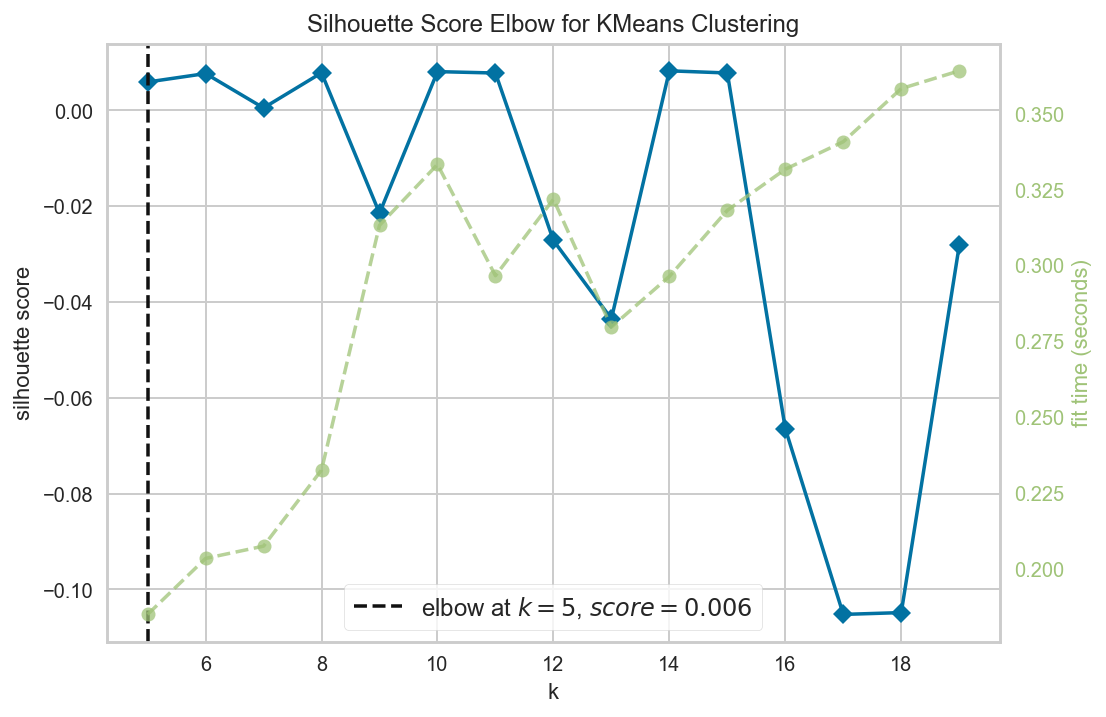

In [1161]:
# Fit the visualizer and plot the results
visualizer.fit(tfidf)       
visualizer.show(outpath='topics.png', dpi=300)

### Try Nouns only @ k=13

In [1162]:
tfidf, nmf = nmf_it(df_genre_nouns['review_lem'],0.15,0.65,13,10,my_stop_words)


Topics in NMF model (Frobenius norm):
Topic #1: piece player solo performance composition composer john saxophonist part note
Topic #2: hiphop sample beat producer production break nothing artist mood funk
Topic #3: guitar rock noise solo play thing start lead melody tone
Topic #4: drum bass percussion beat rhythm funk groove title moment horn
Topic #5: group moment debut member rock lead result percussion drummer saxophonist
Topic #6: tune melody people theme label bit chord genre beat play
Topic #7: piano pianist chord note kind hand melody line composition space
Topic #8: trio drummer moment section line title tone feel bassist member
Topic #9: life world man soul singer day love people thing career
Topic #10: studio session recording version something kind set producer idea release
Topic #11: mix series release set course funk bit start version head
Topic #12: city york part home scene room man feel life beat
Topic #13: voice word string production idea sense feature debut feel bi

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['2021', 'accessibility', 'advertising', 'albums', 'back', 'bandcamp', 'berlin', 'best', 'breakthroughs', 'buy', 'careers', 'chicago', 'contact', 'content', 'critical', 'features', 'festival', 'galleries', 'grammys', 'guides', 'help', 'home', 'influences', 'liner', 'lists', 'longform', 'masthead', 'music', 'new', 'news', 'notes', 'paris', 'photo', 'picks', 'pitch', 'podcast', 'radio', 'records', 'results', 'reviews', 'rising', 'sign', 'sk

**See some topics/genres emerge. Try LDA and see if any better. We may have to resort to selecting key words to get subgenres**

### LDA model

In [1123]:
# Import countVectorizer and LDA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation    

In [1163]:
def lda_it(data,mindf,maxdf,n_components,n_top_words,stop_list):
    '''Fits an LDA model and prints top words for each topic.
    
    Parameters:
        data: DataFrame/Series containing only raw texts
        n_samples: number of texts to sample from data
        n_features: length of TF-IDF vectors to calculate
        n_components: number of topics to model
        n_top_words: number of words to print for each topic, ranked by
            frequency
        stop_list: your list of stopwords to remove
    '''
        
    
    # Get sample of data
    #data_samples = data.sample(n_samples, random_state=1)
    
    # Instantiate and fit TfidfVectorizer
    count_vectorizer = CountVectorizer(max_df=maxdf, min_df=mindf,                                       
                                       stop_words=my_stop_words)

    counts = count_vectorizer.fit_transform(data)
    
    # Fit the LDA model
    lda = LatentDirichletAllocation(n_components=n_components, 
                                    max_iter=5,                                    
                                    random_state=42).fit(counts)

    # View top words for each topic
    print("\nTopics in LDA model (Frobenius norm):")
    counts_feats = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(lda.components_):
        message = "Topic #{}: ".format(topic_idx+1)
        message += " ".join([counts_feats[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    
    return counts, lda

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1164]:
lda_it(df_genre_nouns['review_lem'],0.15,0.65, 13, 10, my_stop_words)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['2021', 'accessibility', 'advertising', 'albums', 'back', 'bandcamp', 'berlin', 'best', 'breakthroughs', 'buy', 'careers', 'chicago', 'contact', 'content', 'critical', 'features', 'festival', 'galleries', 'grammys', 'guides', 'help', 'home', 'influences', 'liner', 'lists', 'longform', 'masthead', 'music', 'new', 'news', 'notes', 'paris', 'photo', 'picks', 'pitch', 'podcast', 'radio', 'records', 'results', 'reviews', 'rising', 'sign', 'sk


Topics in LDA model (Frobenius norm):
Topic #1: performance york part saxophonist show saxophone art solo idea musician
Topic #2: guitar rock solo melody noise thing drum moment project play
Topic #3: tune session thing release studio version solo bit man something
Topic #4: life world man people voice release day name john home
Topic #5: group piano composition note composer player pianist play solo set
Topic #6: beat hiphop drum sample bass break producer rhythm production moment
Topic #7: piece solo player chord moment john play melody place drum
Topic #8: studio recording idea cover piece sense piano kind something note
Topic #9: trio piece section piano composition part player release series material
Topic #10: city part place feature percussion solo space groove composition scene
Topic #11: thing bass rhythm piano section funk something title point label
Topic #12: voice soul singer love pop day line artist man mix
Topic #13: group percussion release bass sax something moment fe

(<624x130 sparse matrix of type '<class 'numpy.int64'>'
 	with 19164 stored elements in Compressed Sparse Row format>,
 LatentDirichletAllocation(max_iter=5, n_components=13, random_state=42))

## Alternative to Topic Modeling for Genre

### Use Genre List from MusicBrainz to match keywords in reviews

### Phrase Matching

In [1315]:
import spacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import PhraseMatcher
phrase_matcher = PhraseMatcher(nlp.vocab)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Function to match phrases in review against music brainz genre list**

In [1422]:
# Phrase Matcher code
#importing all required libraries
import os
from os import listdir
from os.path import isfile, join
from io import StringIO
import pandas as pd
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()
from spacy.matcher import PhraseMatcher

#function that does phrase matching and builds a candidate profile
def create_profile(file):
    
    text = file
    keyword_dict = pd.read_csv('../data/mbrainz_genres.csv')
    stats_words = [nlp(text) for text in keyword_dict['subgenre'].dropna(axis = 0)]

    matcher = PhraseMatcher(nlp.vocab)
    matcher.add('Stats', None, *stats_words)

    doc = nlp(text)
    
    d = []  
    matches = matcher(doc)
    
    for match_id, start, end in matches:
        rule_id = nlp.vocab.strings[match_id]  # get the unicode ID, i.e. 'COLOR'
        span = doc[start : end]  # get the matched slice of the doc
        d.append((rule_id, span.text))      
    keywords = "\n".join(f'{i[0]} {i[1]} ({j})' for i,j in Counter(d).items())
    
    ## convertimg string of keywords to dataframe
    _df = pd.read_csv(StringIO(keywords),names = ['Keywords_List'])
    _df1 = pd.DataFrame(_df.Keywords_List.str.split(' ',1).tolist(),columns = ['Subject','Keyword'])
    _df2 = pd.DataFrame(_df1.Keyword.str.split('(',1).tolist(),columns = ['Keyword', 'Count'])
    _df3 = pd.concat([_df1['Subject'],_df2['Keyword'], _df2['Count']], axis =1) 
    _df3['Count'] = _df3['Count'].apply(lambda x: x.rstrip(")"))
    
    # initialize list of lists 
    cdata = [[i]] 
  
    # Create the pandas DataFrame 
    cdata2 = pd.DataFrame(cdata, columns = ['album']) 
    
    dataf = pd.concat([ cdata2['album'], _df3['Subject'], _df3['Keyword'], _df3['Count']], axis = 1)    
    dataf['album'].fillna(dataf['album'].iloc[0], inplace = True)
    #print("dataf 2",dataf)
    
    return(dataf)
        
#function ends
        
#code to execute/call the above functions
final_database=pd.DataFrame()
i = 0 

for i in range(0,len(df)):
    file = df['review_clean'].iloc[i]
    dat = create_profile(file)
    final_database = final_database.append(dat)
    i +=1

# transpose - convert nans to zero
df_wide = final_database.pivot("album","Keyword","Count")    
df_wide.fillna(0,inplace=True)
print("df wide",df_wide)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


df wide Keyword  NaN acid house  acid jazz  acid rock  acoustic blues  afrobeat   \
album                                                                      
0.0        0           0          0          0               0         0   
1.0        0           0          0          0               0         4   
2.0        0           0          0          0               0         0   
3.0        0           0          0          0               0         0   
4.0        0           0          0          0               0         0   
...      ...         ...        ...        ...             ...       ...   
619.0      0           0          0          0               0         0   
620.0      0           0          0          0               0         0   
621.0      0           0          0          0               0         0   
622.0      0           0          0          0               0         0   
623.0      0           0          0          0               0         0   

Key

### Pickle the file

In [1616]:
import pickle

pickling_on = open("final_database.pickle","wb")
pickle.dump(final_database, pickling_on)
pickling_on.close()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# pickle_off = open("final_database.pickle","rb")
# final_database = pickle.load(pickle_off)

**Get value counts per genre**

In [1423]:
final_database.Keyword.value_counts(1)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


jazz                 0.106478
musical              0.043187
rock                 0.036982
funk                 0.034252
pop                  0.031521
                       ...   
rap rock             0.000248
progressive rock     0.000248
boogiewoogie         0.000248
uk garage            0.000248
klezmer              0.000248
Name: Keyword, Length: 225, dtype: float64

In [1424]:
gen_count=final_database.Keyword.value_counts()
type(gen_count)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


pandas.core.series.Series

In [1425]:
gen_count.to_csv(r'../data/gen_counts.csv')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Viz Ideas - Heatmap - Genre over time<br>
Word cloud of genres**

In [1428]:
final_database.head()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,album,Subject,Keyword,Count
0,0.0,Stats,jazz,2
1,0.0,Stats,free jazz,1
2,0.0,Stats,cloud rap,1
3,0.0,Stats,chiptune,1
4,0.0,Stats,ambient,2


### Bring in review dates - left join the main DF

**rename columns for merge**

In [1447]:
df.rename(columns={'Unnamed: 0': 'revID'} , inplace=True)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1448]:
final_database.rename(columns={'album': 'revID'} , inplace=True)


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1498]:
#test2 = test2["revID"].astype(int)
df_long=final_database.merge(df, on='revID', how='left')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1499]:
df_long_limited=df_long[['Keyword','Count','revdate']]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1500]:
df_long_limited['year'] = df_long_limited['revdate'].dt.year
df_long_limited.drop(['revdate'],axis=1,inplace=True)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1501]:
df_long_limited.head(2)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Keyword,Count,year
0,jazz,2,2021.0
1,free jazz,1,2021.0


In [1502]:
df_long_limited.fillna(0,inplace=True)
df_long_limited['Count']=df_long_limited['Count'].astype(str).astype(int)
df_long_limited.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4040 entries, 0 to 4039
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Keyword  4040 non-null   object 
 1   Count    4040 non-null   int64  
 2   year     4040 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 126.2+ KB


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Group by and Pivot to make genres columns**

In [1472]:
# Gropu by year
x=df_long_limited.groupby(['year']).sum()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1531]:
genre_time=pd.pivot_table(df_long_limited, index = 'year', values = 'Count', columns = 'Keyword', aggfunc = 'sum')
genre_time.fillna(0,inplace=True)
genre_time

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Keyword,0,acid house,acid jazz,acid rock,acoustic blues,afrobeat,ambient,ambient techno,americana,art rock,...,trap,trip hop,turntablism,uk garage,underground hiphop,vocal house,vocal jazz,waltz,west coast hiphop,western swing
year,,,,,,,,,,,,,,,,,,,,,
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2002.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,1.0,0.0,...,2.0,0.0,1.0,0.0,2.0,0.0,0.0,2.0,3.0,0.0
2003.0,0.0,0.0,2.0,0.0,0.0,2.0,7.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2004.0,0.0,0.0,2.0,0.0,0.0,6.0,12.0,0.0,1.0,0.0,...,2.0,0.0,1.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0
2005.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [1532]:
# remove jazz
genre_time.columns = genre_time.columns.str.strip()
genre_time_limited=genre_time.drop('jazz',axis=1)
# transpose
genre_time_T = genre_time_limited.T
genre_time_T

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


year,0.0,1999.0,2000.0,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,...,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0
Keyword,,,,,,,,,,,,,,,,,,,,,
NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
acid house,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
acid jazz,0.0,0.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
acid rock,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
acoustic blues,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vocal house,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
vocal jazz,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
waltz,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0


### Data viz - heatmap of genre over time

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


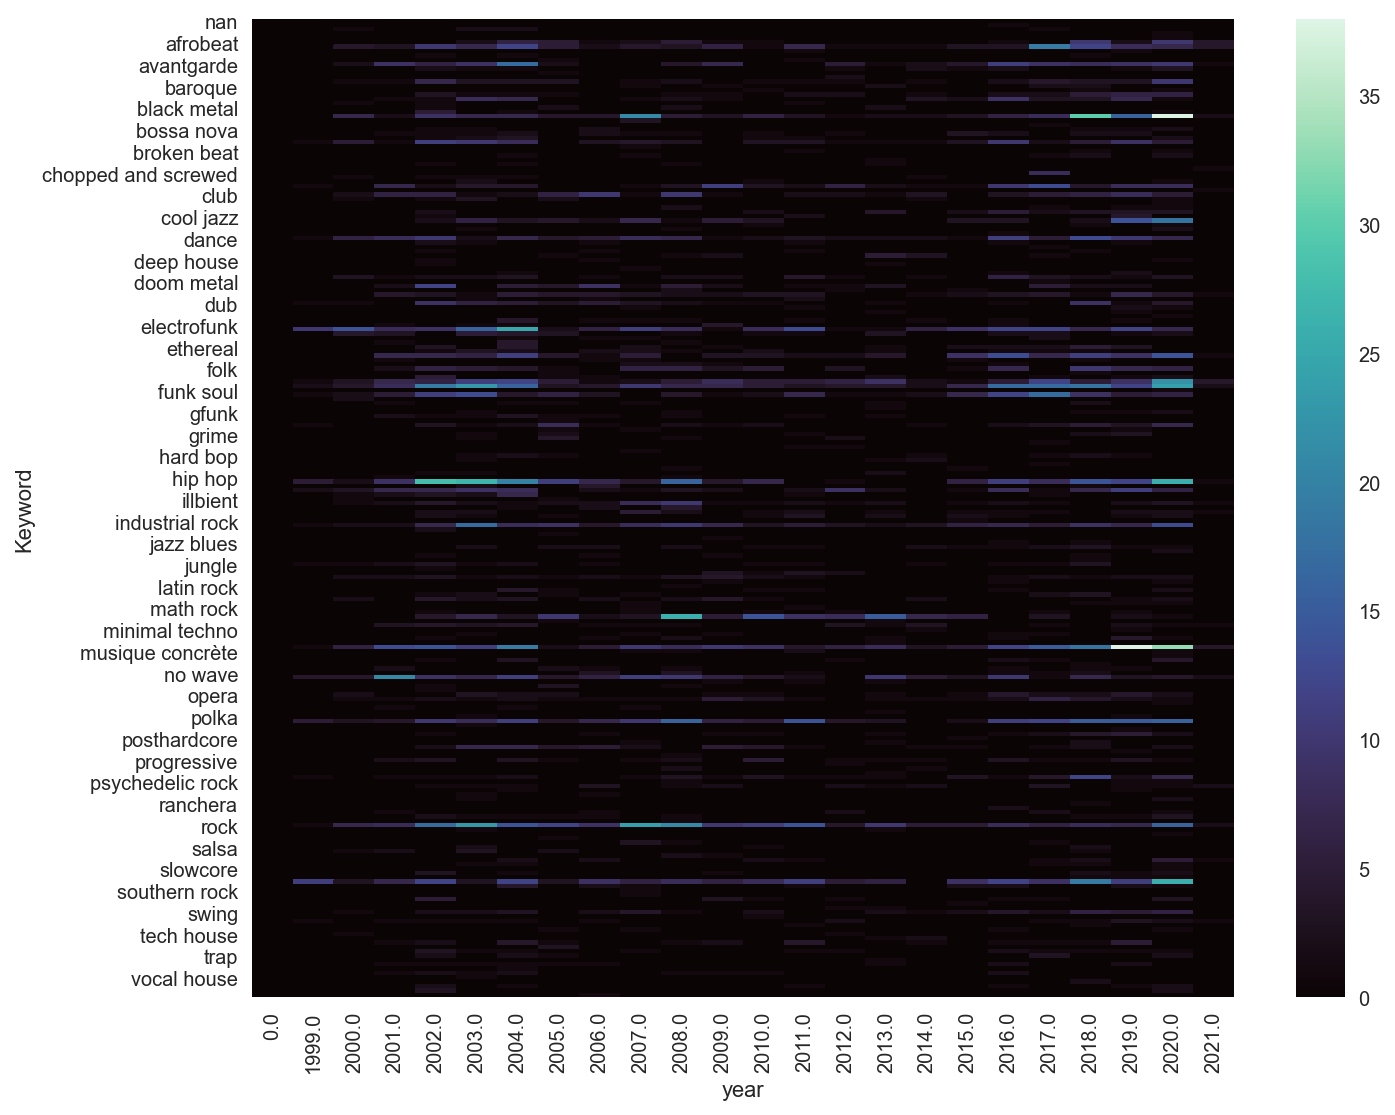

In [1538]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(genre_time_T,fmt="d", cmap="mako")
plt.show()

**Take only the top 30 genres**

In [1542]:
# sum across columns
genre_time_T['total_genres'] = genre_time_T.sum(axis=1)

# sort by total
genre_time_T_top30=genre_time_T.sort_values(by=['total_genres'],ascending=False).nlargest(30, 'total_genres')

# take top 30
genre_time_T_top30.drop(['total_genres'],axis=1,inplace=True)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


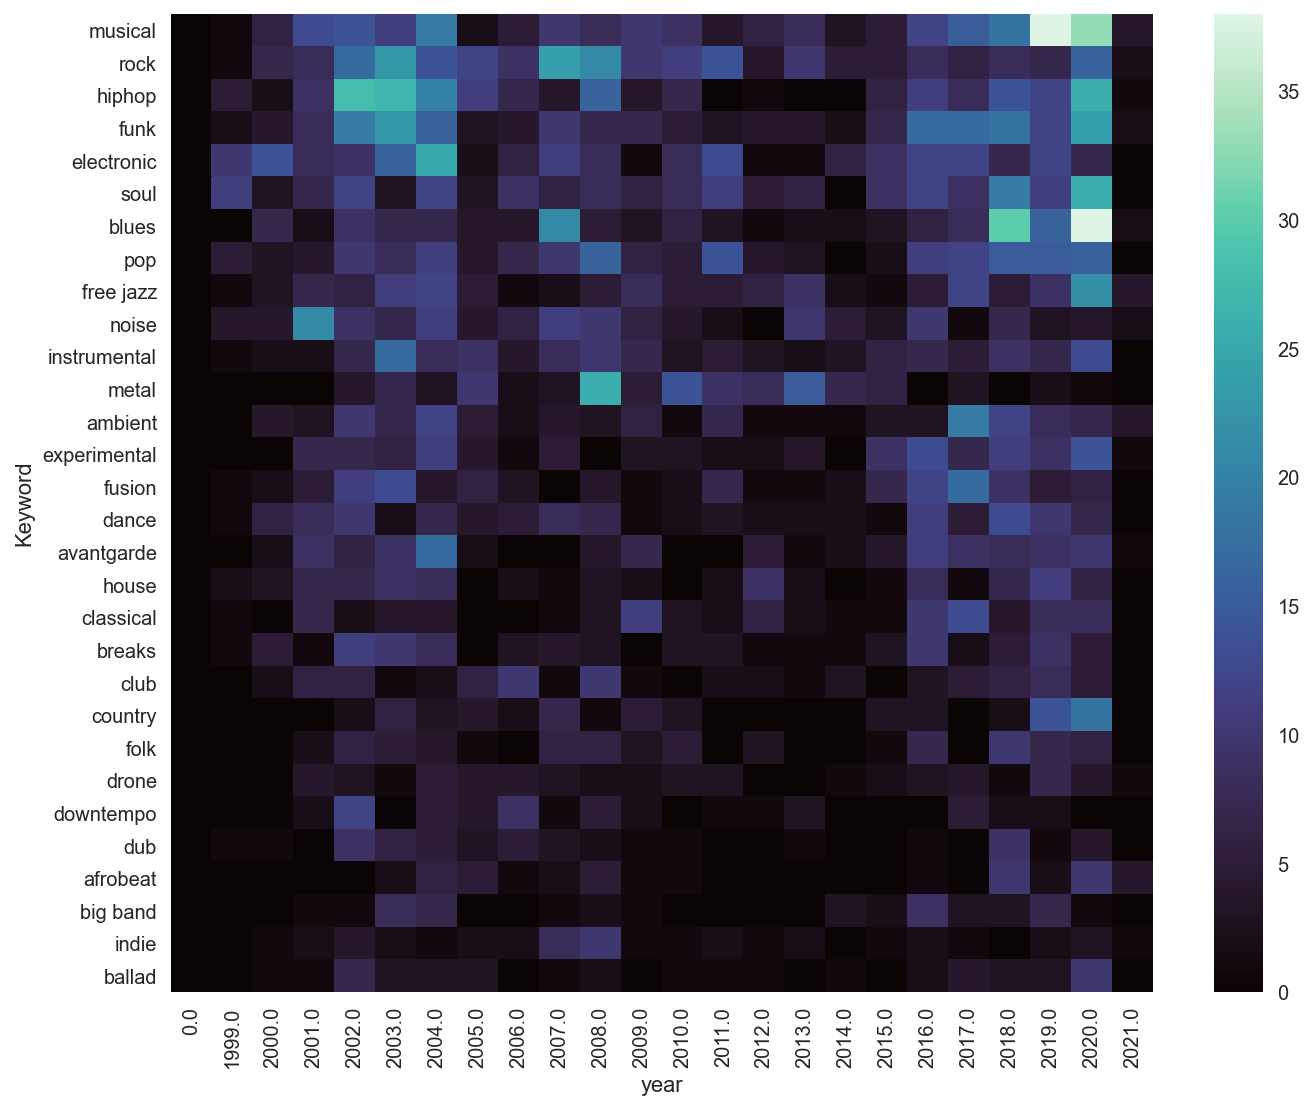

In [1543]:
fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(genre_time_T_top30,fmt="d", cmap="mako")
plt.show()

In [ ]:
import pickle
#pickle.dump(count_matrix, open('count_matrix_tiny.p', 'wb'))


## Add Topic Genre - above sub genres

**Using DF above - pivot/transpose the genres into a list per album**

In [1589]:
# change revID to str for aggregation
df_genre_list = final_database.copy()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1590]:
df_genre_list['revIDstr'] = df_genre_list['revID'].astype(str) # which will by default set the length to the max len it encounters
df_genre_list["Keyword"].fillna("No Genre", inplace = True) 
df_genre_list["Count"].fillna(0,inplace=True)
df_genre_list["Subject"].fillna("Stats",inplace=True)

#df_genre_list['revIDstr'] = df_genre_list['revID'].astype('|S') # which will by default set the length to the max len it encounters
#final_database['revID'] = final_database['revID'].astype(str) #.astype(str)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Group by to put genre into list**

In [1593]:
df_genre_list2 = df_genre_list.groupby('revIDstr').Keyword.agg([('count', 'count'), ('Keyword', ', '.join)])
df_genre_list2.head(3)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,count,Keyword
revIDstr,,
0.0,5,"jazz , free jazz , cloud rap , chiptune , ambi..."
1.0,5,"afrobeat , jazz , funk , hiphop , musical"
10.0,4,"jazz , pop , gospel , musical"


In [1597]:
df_genre_list2.columns

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['count', 'Keyword'], dtype='object')

In [1598]:
df_genre_list2["revID"] = df_genre_list2.index.astype(float)
df_genre_list2

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,count,Keyword,revID
revIDstr,,,
0.0,5,"jazz , free jazz , cloud rap , chiptune , ambi...",0.0
1.0,5,"afrobeat , jazz , funk , hiphop , musical",1.0
10.0,4,"jazz , pop , gospel , musical",10.0
100.0,5,"vocal jazz , jazz , musical , club , house",100.0
101.0,2,"instrumental , blues",101.0
...,...,...,...
95.0,10,"jazz , classical , musical , opera , avantgard...",95.0
96.0,7,"jazz , free jazz , dub , hiphop , soca , grime...",96.0
97.0,5,"hiphop , classical , jazz , gospel , avantgarde",97.0


### Output files to work with in Streamlit

**Wide DF (album level)**

In [1602]:
# merge album level - genres strings into album level with genre flags
df_genre_list_mrg=df_long.merge(df_genre_list2, on='revID', how='left')
df_genre_list_mrg.head(2)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,revID,Subject,Keyword_x,Count,artist,album,score,genre,review,othercat2,...,review_clean,othercat_clean,artist_clean,album_clean,revdate,review_lem,review_clean2,totalwords,count,Keyword_y
0,0.0,Stats,jazz,2,Sam Gendel,Fresh Bread,6.5,Jazz,"Fifty-two tracks deep, this archival compendiu...","Sam Gendel, Jay Balfour, Sam Gendel, cover...",...,fiftytwo tracks deep this archival compendium ...,"sam gendel, jay balfour, sam gendel, cover...",sam gendel,fresh bread,2021-03-04,fiftytwo track deep this archival compendium m...,fiftytwo tracks deep this archival compendium ...,600,5,"jazz , free jazz , cloud rap , chiptune , ambi..."
1,0.0,Stats,free jazz,1,Sam Gendel,Fresh Bread,6.5,Jazz,"Fifty-two tracks deep, this archival compendiu...","Sam Gendel, Jay Balfour, Sam Gendel, cover...",...,fiftytwo tracks deep this archival compendium ...,"sam gendel, jay balfour, sam gendel, cover...",sam gendel,fresh bread,2021-03-04,fiftytwo track deep this archival compendium m...,fiftytwo tracks deep this archival compendium ...,600,5,"jazz , free jazz , cloud rap , chiptune , ambi..."


In [1611]:
# Drop subject, keyword x and count
df_genre_list_mrg.drop(['Subject','Keyword_x','Count'],axis=1,inplace=True)

# dropping duplicate values 
df_genre_list_nodup = df_genre_list_mrg.drop_duplicates(subset='revID',keep='first') 
  
# length after removing duplicates 
df_genre_list_nodup.shape

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(624, 18)

In [1612]:
df_genre_list_nodup.head(2)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,revID,artist,album,score,genre,review,othercat2,best,review_clean,othercat_clean,artist_clean,album_clean,revdate,review_lem,review_clean2,totalwords,count,Keyword_y
0,0.0,Sam Gendel,Fresh Bread,6.5,Jazz,"Fifty-two tracks deep, this archival compendiu...","Sam Gendel, Jay Balfour, Sam Gendel, cover...",0,fiftytwo tracks deep this archival compendium ...,"sam gendel, jay balfour, sam gendel, cover...",sam gendel,fresh bread,2021-03-04,fiftytwo track deep this archival compendium m...,fiftytwo tracks deep this archival compendium ...,600,5,"jazz , free jazz , cloud rap , chiptune , ambi..."
5,1.0,Femi Kuti / Made Kuti,Legacy +,7.8,Global,"On the duo’s generation-spanning double album,...","Femi Kuti, Made Kuti, Joey Akan, Global, F...",0,on the duo’s generationspanning double album f...,"femi kuti, made kuti, joey akan, global, f...",femi kuti / made kuti,legacy +,2021-02-20,on the duo ’s generationspanne double album fe...,on the duo s generationspanning double album f...,493,5,"afrobeat , jazz , funk , hiphop , musical"


**Get all sub-genres as columns**

In [1613]:
df_genre_bools =df_long[['revID','Keyword','Count']]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1614]:
df_genre_bools.fillna(0,inplace=True)
df_genre_bools['Count']=df_genre_bools['Count'].astype(str).astype(int)
df_genre_bools.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4040 entries, 0 to 4039
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   revID    4040 non-null   float64
 1   Keyword  4040 non-null   object 
 2   Count    4040 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 126.2+ KB


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Group by and Pivot to make genres columns**

In [1615]:
df_genre_bools_list=pd.pivot_table(df_genre_bools, index = 'revID', values = 'Count', columns = 'Keyword', aggfunc = 'sum')
df_genre_bools_list.fillna(0,inplace=True)
df_genre_bools_list.head(2)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Keyword,0,acid house,acid jazz,acid rock,acoustic blues,afrobeat,ambient,ambient techno,americana,art rock,...,trap,trip hop,turntablism,uk garage,underground hiphop,vocal house,vocal jazz,waltz,west coast hiphop,western swing
revID,,,,,,,,,,,,,,,,,,,,,
0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1664]:
# Drop cols 0
df_genre_bools_list.drop([0],axis=1,inplace=True)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Merge with wide file list**

In [1752]:
df_genre_stream_wide=df_genre_bools_list.merge(df_genre_list_nodup, on='revID', how='left')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Output wide file to csv

In [1753]:
cols = df_genre_stream_wide.columns.tolist()
cols = cols[-17:] + cols[:-17]
cols

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['artist',
 'album',
 'score',
 'genre',
 'review',
 'othercat2',
 'best',
 'review_clean',
 'othercat_clean',
 'artist_clean',
 'album_clean',
 'revdate',
 'review_lem',
 'review_clean2',
 'totalwords',
 'count',
 'Keyword_y',
 'revID',
 'acid house ',
 'acid jazz ',
 'acid rock ',
 'acoustic blues ',
 'afrobeat ',
 'ambient ',
 'ambient techno ',
 'americana ',
 'art rock ',
 'avantgarde ',
 'avantgarde jazz ',
 'avantgarde metal ',
 'avantprog ',
 'ballad ',
 'baroque ',
 'beat music ',
 'bebop ',
 'big band ',
 'big beat ',
 'black metal ',
 'bluegrass ',
 'blues ',
 'bolero ',
 'boogiewoogie ',
 'bossa nova ',
 'bounce ',
 'breakbeat ',
 'breaks ',
 'britpop ',
 'broken beat ',
 'calypso ',
 'celtic ',
 'chillout ',
 'chiptune ',
 'chopped and screwed ',
 'classic jazz ',
 'classic rock ',
 'classical ',
 'cloud rap ',
 'club ',
 'comedy ',
 'conscious hiphop ',
 'contemporary classical ',
 'contemporary jazz ',
 'cool jazz ',
 'country ',
 'country blues ',
 'cumbia ',
 'cyberpun

In [1754]:
df_genre_stream_wide = df_genre_stream_wide[cols]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1755]:
df_genre_stream_wide.head(2)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,artist,album,score,genre,review,othercat2,best,review_clean,othercat_clean,artist_clean,...,trap,trip hop,turntablism,uk garage,underground hiphop,vocal house,vocal jazz,waltz,west coast hiphop,western swing
0,Sam Gendel,Fresh Bread,6.5,Jazz,"Fifty-two tracks deep, this archival compendiu...","Sam Gendel, Jay Balfour, Sam Gendel, cover...",0,fiftytwo tracks deep this archival compendium ...,"sam gendel, jay balfour, sam gendel, cover...",sam gendel,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Femi Kuti / Made Kuti,Legacy +,7.8,Global,"On the duo’s generation-spanning double album,...","Femi Kuti, Made Kuti, Joey Akan, Global, F...",0,on the duo’s generationspanning double album f...,"femi kuti, made kuti, joey akan, global, f...",femi kuti / made kuti,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1756]:
# There are 2 cols that need to be dropped. the index and a column full of zeros
df_genre_stream_wide.rename(columns={'Keyword_y': 'Keyword'},inplace=True)
df_genre_stream_wide.set_index('artist')
df_genre_stream_wide.to_csv(r'../data/df_genre_stream_wide.csv')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Wide mini file - Create DF with album and keywords**

In [1758]:
# dont forget to remove the index column when outputting
df_small_wide= df_genre_stream_wide[['artist','album','Keyword']]
df_small_wide.head(2)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,artist,album,Keyword
0,Sam Gendel,Fresh Bread,"jazz , free jazz , cloud rap , chiptune , ambi..."
1,Femi Kuti / Made Kuti,Legacy +,"afrobeat , jazz , funk , hiphop , musical"


In [1759]:
df_small_wide.to_csv(r'../data/df_stream_wide_sm.csv')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Output long file to csv

In [1760]:
# Drop subject (stats) and rearrange order.
# Set artist as index
df_genre_stream_long= df_long.drop(['Subject'],axis=1)
df_genre_stream_long.rename(columns={'Count': 'count'},inplace=True)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1761]:
longcols = df_genre_stream_long.columns.tolist()
longcols = longcols[-15:] + longcols[:-15]
longcols

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['artist',
 'album',
 'score',
 'genre',
 'review',
 'othercat2',
 'best',
 'review_clean',
 'othercat_clean',
 'artist_clean',
 'album_clean',
 'revdate',
 'review_lem',
 'review_clean2',
 'totalwords',
 'revID',
 'Keyword',
 'count']

In [1762]:
df_genre_stream_long = df_genre_stream_long[longcols]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1763]:
df_genre_stream_long.set_index('artist')
df_genre_stream_long.to_csv(r'../data/df_genre_stream_long.csv')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1772]:
test = df_genre_stream_long.loc[6,'album']='testing'
test

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'testing'

In [1691]:
test = pd.read_csv('../data/df_genre_stream_wide.csv', index_col=0)    
test.head(2)

# title = ['Sam Gendel']
# indices_test = ['Sam Gendel','ABC','XYZ']
# indices = pd.Series(indices_test)
# indices[0]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,artist,album,score,genre,review,othercat2,best,review_clean,othercat_clean,artist_clean,...,trap,trip hop,turntablism,uk garage,underground hiphop,vocal house,vocal jazz,waltz,west coast hiphop,western swing
0,Sam Gendel,Fresh Bread,6.5,Jazz,"Fifty-two tracks deep, this archival compendiu...","Sam Gendel, Jay Balfour, Sam Gendel, cover...",0,fiftytwo tracks deep this archival compendium ...,"sam gendel, jay balfour, sam gendel, cover...",sam gendel,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Femi Kuti / Made Kuti,Legacy +,7.8,Global,"On the duo’s generation-spanning double album,...","Femi Kuti, Made Kuti, Joey Akan, Global, F...",0,on the duo’s generationspanning double album f...,"femi kuti, made kuti, joey akan, global, f...",femi kuti / made kuti,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1632]:
indices_test = pd.Series(df_small_wide['artist'])
print(indices_test)

0                      Sam Gendel
1           Femi Kuti / Made Kuti
2      Archie Shepp / Jason Moran
3                Patricia Brennan
4                Baldi/Gerycz Duo
                  ...            
619                    Jimi Tenor
620                The Herbaliser
621             Nightmares on Wax
622                  Roots Manuva
623                       Coldcut
Name: artist, Length: 624, dtype: object


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Other Topics and sliders/buttons
- Instruments (based on topic modeling, nouns??)
- Emotions (see what to keep based on lexicon)
- Sentiment (if not already parsed from above)
- Mentions? this could be in EDA

**Additional**
- link to artist and song
- image of top artist / album
- network graphing

## Add Topics (textual)

## Add Emotions

In [1783]:
import pandas as pd
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer

import time
import pandas as pd
import requests

from tqdm import tqdm

def text_emotion(df, column):
    '''
    Takes a DataFrame and a specified column of text and adds 10 columns to the
    DataFrame for each of the 10 emotions in the NRC Emotion Lexicon, with each
    column containing the value of the text in that emotions
    INPUT: DataFrame, string
    OUTPUT: the original DataFrame with ten new columns
    '''

    df_emo = df.copy()

    filepath = ('../data/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt')
    emolex_df = pd.read_csv(filepath,
                            names=["word", "emotion", "association"],
                            sep='\t')
    emolex_words = emolex_df.pivot(index='word',
                                   columns='emotion',
                                   values='association').reset_index()
    emotions = emolex_words.columns.drop('word')
    emo_df = pd.DataFrame(0, index=df.index, columns=emotions)

    stemmer = SnowballStemmer("english")

    
    book = ''
    chapter = ''
    
    with tqdm(total=len(list(df_emo.iterrows()))) as pbar:
        for i, row in df_emo.iterrows():
            pbar.update(1)
            document = word_tokenize(df_emo.loc[i][column])
            for word in document:
                word = stemmer.stem(word.lower())
                emo_score = emolex_words[emolex_words.word == word]
                if not emo_score.empty:
                    for emotion in list(emotions):
                        emo_df.at[i, emotion] += emo_score[emotion]

    df_emo = pd.concat([df_emo, emo_df], axis=1)

    return df_emo

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1784]:
df_emo2 = text_emotion(df, 'review_lem')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 624/624 [16:39<00:00,  1.60s/it]


In [1775]:
df_emo2.head(2)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,revID,artist,album,score,genre,review,othercat2,best,review_clean,othercat_clean,...,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,0,Sam Gendel,Fresh Bread,6.5,Jazz,"Fifty-two tracks deep, this archival compendiu...","Sam Gendel, Jay Balfour, Sam Gendel, cover...",0,fiftytwo tracks deep this archival compendium ...,"sam gendel, jay balfour, sam gendel, cover...",...,4,17,1,6,8,9,16,8,7,9
1,1,Femi Kuti / Made Kuti,Legacy +,7.8,Global,"On the duo’s generation-spanning double album,...","Femi Kuti, Made Kuti, Joey Akan, Global, F...",0,on the duo’s generationspanning double album f...,"femi kuti, made kuti, joey akan, global, f...",...,8,10,6,6,9,13,34,10,9,16


### count words and standardize the emotion counts

In [1778]:
from nltk import tokenize
df_emo3 = df_emo2.copy()
df_emo3['word_count'] = df_emo3['review_lem'].apply(tokenize.word_tokenize).apply(len)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1779]:
emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1780]:
for emotion in emotions:
    df_emo3[emotion] = df_emo3[emotion] / df_emo3['word_count']

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1781]:
df_emo3.head(2)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,revID,artist,album,score,genre,review,othercat2,best,review_clean,othercat_clean,...,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,word_count
0,0,Sam Gendel,Fresh Bread,6.5,Jazz,"Fifty-two tracks deep, this archival compendiu...","Sam Gendel, Jay Balfour, Sam Gendel, cover...",0,fiftytwo tracks deep this archival compendium ...,"sam gendel, jay balfour, sam gendel, cover...",...,0.026034,0.001531,0.009188,0.012251,0.013783,0.024502,0.012251,0.010720,0.013783,653
1,1,Femi Kuti / Made Kuti,Legacy +,7.8,Global,"On the duo’s generation-spanning double album,...","Femi Kuti, Made Kuti, Joey Akan, Global, F...",0,on the duo’s generationspanning double album f...,"femi kuti, made kuti, joey akan, global, f...",...,0.017544,0.010526,0.010526,0.015789,0.022807,0.059649,0.017544,0.015789,0.028070,570


In [1782]:
df_emo3.describe()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,revID,score,best,totalwords,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,word_count
count,624.000000,615.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000
mean,311.500000,7.428618,0.070513,710.939103,0.009055,0.021551,0.005826,0.011070,0.018480,0.024874,0.043683,0.016039,0.009816,0.021585,741.918269
std,180.277564,1.157300,0.256215,289.938621,0.005644,0.007659,0.004830,0.006807,0.007609,0.010078,0.011772,0.007478,0.005099,0.007994,311.733791
min,0.000000,1.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000
25%,155.750000,7.000000,0.000000,537.500000,0.005323,0.016380,0.002654,0.006534,0.013319,0.018322,0.036972,0.011045,0.006751,0.016302,563.000000
50%,311.500000,7.600000,0.000000,645.000000,0.008024,0.021173,0.004912,0.010050,0.017787,0.023715,0.043690,0.015038,0.009126,0.021167,671.000000
75%,467.250000,8.000000,0.000000,815.250000,0.011761,0.026029,0.007683,0.014229,0.022781,0.030600,0.051282,0.019881,0.012369,0.026405,849.500000
max,623.000000,10.000000,1.000000,2157.000000,0.040073,0.058407,0.049180,0.063752,0.043517,0.072860,0.088477,0.054645,0.030756,0.057181,2308.000000


### Idea - to use emotions either as levers or simply descriptive attributes of an albums review (radars or otherwise)

In [1209]:
df.columns

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['Unnamed: 0', 'artist', 'album', 'score', 'genre', 'review',
       'othercat2', 'best', 'review_clean', 'othercat_clean', 'artist_clean',
       'album_clean', 'revdate', 'review_lem', 'review_clean2', 'totalwords'],
      dtype='object')

In [1210]:
df_genre.head(3)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed: 0,artist,album,score,genre,review,othercat2,best,review_clean,othercat_clean,...,"west coast swing,","western swing,","witch house,","wonky,","yacht rock,","yé-yé,","zamrock,","zeuhl,","zouk,","zydeco,"
0,0,Sam Gendel,Fresh Bread,6.5,Jazz,"Fifty-two tracks deep, this archival compendiu...","Sam Gendel, Jay Balfour, Sam Gendel, cover...",0,fiftytwo tracks deep this archival compendium ...,"sam gendel, jay balfour, sam gendel, cover...",...,0,0,0,0,0,0,0,0,0,0
1,1,Femi Kuti / Made Kuti,Legacy +,7.8,Global,"On the duo’s generation-spanning double album,...","Femi Kuti, Made Kuti, Joey Akan, Global, F...",0,on the duo’s generationspanning double album f...,"femi kuti, made kuti, joey akan, global, f...",...,0,0,0,0,0,0,0,0,0,0
2,2,Archie Shepp / Jason Moran,Let My People Go,7.5,Jazz,These live sets between the saxophonist and pi...,"Archie Shepp, Jason Moran, Madison Bloom, ...",0,these live sets between the saxophonist and pi...,"archie shepp, jason moran, madison bloom, ...",...,0,0,0,0,0,0,0,0,0,0


In [1175]:
mbcsv = open('/Users/chrischan/Documents/02_Class/Metis/bootcamp/githubrepo/Metis_proj5/data/mbrainz_genres.csv', 'r')
mbread = mbcsv.read()
print(mbread)

acid house,
acid jazz,
acid rock,
acid techno,
acoustic blues,
acoustic rock,
afoxê,
afrobeat,
alternative country,
alternative dance,
alternative folk,
alternative hip hop,
alternative metal,
alternative pop,
alternative punk,
alternative rock,
ambient,
ambient dub,
ambient house,
ambient techno,
americana,
anarcho-punk,
aor,
arena rock,
art pop,
art punk,
art rock,
atmospheric black metal,
audiobook,
avant-garde,
avant-garde jazz,
avant-garde metal,
avant-garde pop,
avant-prog,
bachata,
ballad,
barbershop,
bardcore,
baroque,
bass house,
beat music,
bebop,
bhangra,
big band,
big beat,
black metal,
blackened death metal,
blackgaze,
bleep techno,
blue-eyed soul,
bluegrass,
blues,
blues rock,
bolero,
bolero son,
bongo flava,
boogie rock,
boogie-woogie,
boom bap,
bossa nova,
bounce,
breakbeat,
breakbeat hardcore,
breakcore,
breaks,
britpop,
broken beat,
brostep,
brutal death metal,
bubblegum pop,
cajun,
calypso,
candombe,
canterbury scene,
cantopop,
carnatic classical,
celtic,
celtic punk

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1178]:
_mblist = mbread.split(",")
mbcsv.close()

mblist = []
for element in _mblist:
    mblist.append(element.strip())

mblist.pop() # last element was blank
print(mblist)

['acid house', 'acid jazz', 'acid rock', 'acid techno', 'acoustic blues', 'acoustic rock', 'afoxê', 'afrobeat', 'alternative country', 'alternative dance', 'alternative folk', 'alternative hip hop', 'alternative metal', 'alternative pop', 'alternative punk', 'alternative rock', 'ambient', 'ambient dub', 'ambient house', 'ambient techno', 'americana', 'anarcho-punk', 'aor', 'arena rock', 'art pop', 'art punk', 'art rock', 'atmospheric black metal', 'audiobook', 'avant-garde', 'avant-garde jazz', 'avant-garde metal', 'avant-garde pop', 'avant-prog', 'bachata', 'ballad', 'barbershop', 'bardcore', 'baroque', 'bass house', 'beat music', 'bebop', 'bhangra', 'big band', 'big beat', 'black metal', 'blackened death metal', 'blackgaze', 'bleep techno', 'blue-eyed soul', 'bluegrass', 'blues', 'blues rock', 'bolero', 'bolero son', 'bongo flava', 'boogie rock', 'boogie-woogie', 'boom bap', 'bossa nova', 'bounce', 'breakbeat', 'breakbeat hardcore', 'breakcore', 'breaks', 'britpop', 'broken beat', 'b

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1137]:
from gensim.corpora.dictionary import Dictionary

def vectorize_vis(data, min_df,max_df):
    vec = CountVectorizer(stop_words=my_stop_words, min_df=min_df, max_df=max_df) #, ngram_range=(1, 3)
    doc_word = vec.fit_transform(data)
    feature_names = vec.get_feature_names()
    id2word = dict((v, k) for k, v in vec.vocabulary_.items())
    dictionary = Dictionary([feature_names])
    
    return doc_word, feature_names, id2word, dictionary

In [1138]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

def lda_vis(doc_word, feature_names, id2word, dictionary, num_topics):
    corpus = matutils.Sparse2Corpus(doc_word.transpose())
    model = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=5, random_state=42)    
    topics = model.print_topics(num_words=50)
    for n, topic in topics:
        print("\nTopic ", n)
        print(topic)

    vis_data = pyLDAvis.gensim.prepare(model, corpus, dictionary)
    return vis_data

In [1147]:
doc_word, feature_names, id2word, dictionary = vectorize_vis(df_genre_nouns['review_lem'], 0.10,.75)
vis_data = lda_vis(doc_word, feature_names, id2word, dictionary, 10)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['2021', 'accessibility', 'advertising', 'albums', 'back', 'bandcamp', 'berlin', 'best', 'breakthroughs', 'buy', 'careers', 'chicago', 'contact', 'content', 'critical', 'features', 'festival', 'galleries', 'grammys', 'guides', 'help', 'home', 'influences', 'liner', 'lists', 'longform', 'masthead', 'music', 'new', 'news', 'notes', 'paris', 'photo', 'picks', 'pitch', 'podcast', 'radio', 'records', 'results', 'reviews', 'rising', 'sign', 'sk


Topic  0
0.027*"track" + 0.023*"record" + 0.021*"thing" + 0.020*"sound" + 0.018*"guitar" + 0.015*"group" + 0.014*"rock" + 0.014*"percussion" + 0.014*"moment" + 0.014*"part" + 0.013*"voice" + 0.013*"place" + 0.013*"piece" + 0.013*"idea" + 0.012*"melody" + 0.012*"word" + 0.011*"project" + 0.011*"musician" + 0.011*"feel" + 0.011*"improvisation" + 0.010*"scene" + 0.010*"drum" + 0.009*"cover" + 0.009*"feature" + 0.009*"point" + 0.009*"player" + 0.009*"sense" + 0.008*"name" + 0.008*"city" + 0.008*"duo" + 0.008*"play" + 0.007*"folk" + 0.007*"solo" + 0.007*"harmony" + 0.007*"use" + 0.007*"horn" + 0.007*"something" + 0.007*"debut" + 0.007*"john" + 0.007*"star" + 0.007*"pop" + 0.007*"collaborator" + 0.007*"room" + 0.006*"note" + 0.006*"lead" + 0.006*"composition" + 0.006*"move" + 0.006*"share" + 0.006*"result" + 0.006*"line"

Topic  1
0.050*"track" + 0.031*"sound" + 0.020*"piano" + 0.019*"group" + 0.016*"pianist" + 0.015*"trio" + 0.014*"record" + 0.014*"moment" + 0.014*"sense" + 0.014*"solo" + 

In [1148]:
pyLDAvis.display(vis_data)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=500)

index = similarities.MatrixSimilarity(lsi[corpus])

text_input = 'Franconia Amber'

def get_beer_keywords(text_input):
    input_beer_keywords = []
    for item in sorted(corpus_tfidf[beers[beers.name == text_input].index[0]], key = lambda x: -x[1])[:5]:
        input_beer_keywords.append(dictionary[item[0]])
    return input_beer_keywords

beers['keywords'] = beers.name.map(get_beer_keywords)
get_beer_keywords(text_input)

def get_similar_beers(text_input):
    try:
        doc = documents[beers[beers.name == text_input].index[0]]
        beer_name_inputted = 1
    except IndexError:
        doc = text_input
        beer_name_inputted = 0
    vec_bow = dictionary.doc2bow(doc.lower().split())
    vec_lsi = lsi[vec_bow]

    sims = index[vec_lsi]
    similar_beers = []
    for beer in sorted(enumerate(sims), key = lambda x: -x[1])[beer_name_inputted:beer_name_inputted+5]:
        similar_beers.append((beer[0],beer[1]))

    return similar_beers

beers['similar_beers'] = beers.name.map(get_similar_beers)
get_similar_beers(text_input)

similar_beers = beers.similar_beers.iloc[0]

def get_recs_from_input(text_input):
    beer_name_inputted = True

    similar_beer_ids = list(beers[beers.name == text_input].similar_beers)
    similar_beers = [beer[0] for beer in similar_beer_ids[0]]
    similar_beers = beers.iloc[similar_beers]
    return (similar_beers ,beer_name_inputted)


get_recs_from_input(text_input)[0]

### Topic Modeling

In [805]:
def lsa(doc_word, feature_names, num_topics):
    model = TruncatedSVD(num_topics)
    doc_topic = model.fit_transform(doc_word)
    for ix, topic in enumerate(model.components_):
        print("\nTopic ", ix)
        print(", ".join([feature_names[i] for i in topic.argsort()[:-21:-1]]))

def nmf(doc_word, feature_names, num_topics):
    model = NMF(num_topics)
    doc_topic = model.fit_transform(doc_word)
    for ix, topic in enumerate(model.components_):
        print("\nTopic ", ix)
        print(", ".join([feature_names[i] for i in topic.argsort()[:-75:-1]]))

def lda(doc_word, feature_names, id2word, num_topics):
    corpus = matutils.Sparse2Corpus(doc_word.transpose())
    model = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=5, random_state=42)
    topics = model.print_topics(num_words=50)
    for n, topic in topics:
        print("\nTopic ", n)
        print(topic)
        

def corex(doc_word, feature_names, num_topics):
    words = list(np.asarray(feature_names))
    model = corextopic.Corex(n_hidden=num_topics, words=words, seed=1, max_iter=200)
    model.fit(doc_word, words=words, docs=data) # where data = df["Lemmatized"]
    topics = model.get_topics()
    for n,topic in enumerate(topics):
        topic_words,_ = zip(*topic)
        print('{}: '.format(n) + ','.join(topic_words))
        
def vectorize_2(data, min_df,max_df):
    vec = CountVectorizer(stop_words=my_stop_words,  min_df=min_df , max_df=max_df) #ngram_range=(1, 3)
    doc_word = vec.fit_transform(data)
    feature_names = vec.get_feature_names()
    id2word = dict((v, k) for k, v in vec.vocabulary_.items())
    
    return doc_word, feature_names, id2word        

### NMF with min/max df

In [843]:
data_grg = df_sent_grg["lemmatized"]
#data_pos = df_sent_grg_pos["lemmatized"]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [871]:
doc_word, feature_names, id2word= vectorize_2(data_grg,.03,.55)
nmf(doc_word, feature_names, 5)


Topic  0
hand, kramer, parent, leave, big, move, point, thank, happen, mean, maybe, walk, life, salad, much, even, laugh, apartment, eat, stop, need, play, door, man, kid, face, sorry, sit, check, father, hear, work, turn, table, god, dinner, hold, arm, use, dad, year, lunch, mother, find, please, ever, nice, money, wear, job, buy, kind, break, fine, mind, try, room, another, chuckle, anymore, clothe, shirt, shake, whole, place, pick, raise, head, heh, plan, live, may, help, people

Topic  1
car, bar, first, space, candy, move, dollar, park, big, people, maybe, pull, lot, even, pay, parking, walk, great, front, head, spot, door, sorry, start, leave, buy, kramer, need, help, turn, mean, hat, away, window, day, wait, stop, try, drive, name, nobody, anything, hear, sure, stand, coat, believe, kid, please, open, run, hospital, twenty, pick, wrong, might, change, excuse, fine, another, minute, doubt, ask, store, susan, father, chair, heh, bother, nice, listen, fall, much, elaine

Topic  2


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


## LDA with min/max df

In [845]:
from gensim.corpora.dictionary import Dictionary

def vectorize_vis(data, min_df,max_df):
    vec = CountVectorizer(stop_words=my_stop_words, min_df=min_df, max_df=max_df) #, ngram_range=(1, 3)
    doc_word = vec.fit_transform(data)
    feature_names = vec.get_feature_names()
    id2word = dict((v, k) for k, v in vec.vocabulary_.items())
    dictionary = Dictionary([feature_names])
    
    return doc_word, feature_names, id2word, dictionary

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [846]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

def lda_vis(doc_word, feature_names, id2word, dictionary, num_topics):
    corpus = matutils.Sparse2Corpus(doc_word.transpose())
    model = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=5, random_state=42)    
    topics = model.print_topics(num_words=50)
    for n, topic in topics:
        print("\nTopic ", n)
        print(topic)

    vis_data = pyLDAvis.gensim.prepare(model, corpus, dictionary)
    return vis_data

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [868]:
doc_word, feature_names, id2word, dictionary = vectorize_vis(data_grg, 0.03,.65)

vis_data = lda_vis(doc_word, feature_names, id2word, dictionary, 5)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Topic  0
0.010*"elaine" + 0.010*"kramer" + 0.010*"something" + 0.009*"talk" + 0.008*"call" + 0.008*"woman" + 0.008*"happen" + 0.008*"time" + 0.007*"little" + 0.007*"even" + 0.007*"give" + 0.007*"george" + 0.007*"anything" + 0.007*"people" + 0.007*"show" + 0.007*"never" + 0.007*"stop" + 0.007*"need" + 0.007*"great" + 0.006*"mean" + 0.006*"yes" + 0.006*"day" + 0.006*"try" + 0.006*"nothing" + 0.006*"leave" + 0.005*"maybe" + 0.005*"buy" + 0.005*"ask" + 0.005*"nice" + 0.005*"name" + 0.005*"big" + 0.005*"start" + 0.005*"hear" + 0.005*"care" + 0.005*"laugh" + 0.005*"sorry" + 0.005*"friend" + 0.005*"point" + 0.005*"believe" + 0.005*"excuse" + 0.004*"live" + 0.004*"funny" + 0.004*"meet" + 0.004*"lot" + 0.004*"minute" + 0.004*"phone" + 0.004*"wait" + 0.004*"first" + 0.004*"always" + 0.004*"guy"

Topic  1
0.012*"call" + 0.010*"yes" + 0.009*"something" + 0.009*"george" + 0.008*"guy" + 0.008*"big" + 0.008*"little" + 0.008*"try" + 0.008*"wait" + 0.007*"give" + 0.007*"talk" + 0.007*"happen" + 0.006*

In [869]:
pyLDAvis.display(vis_data)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
